In [132]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import os
from datetime import datetime, timedelta
from dateutil.relativedelta import relativedelta

import xgboost as xg

from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error

In [133]:
__ROOT_PATH__ = Path(__name__).resolve().parent.parent
datasets_path = __ROOT_PATH__ / "data"

In [134]:
dataframes = dict()

for file in os.listdir(datasets_path):
    if file.lower().endswith(".csv"):
        dataset_file = pd.read_csv(datasets_path / file, decimal=".")

        file_name = file.split(".")[0]
        dataframes[file_name] = dataset_file

    else:
        print("File does not correspond to the specified extension (.csv)")

File does not correspond to the specified extension (.csv)


In [135]:
dataframes["iron_ore"] = dataframes.pop("Iron ore fines 62% Fe CFR Futures Historical Data")
dataframes["hot_rolled_coil"] = dataframes.pop("US Midwest Domestic Hot-Rolled Coil Steel Futures Historical Data")
dataframes["usd_index"] = dataframes.pop("US Dollar Index Futures Historical Data")
dataframes["steel_scrap"] = dataframes.pop("Steel Scrap Futures Historical Data")

In [136]:
def stock_market_treatment(dictionary:dict):
    for key, dataset in dictionary.items():
        if not str(key).endswith("_br"):
            dictionary[key] = dataset.loc[:,["Date", "Price"]]
            dictionary[key].columns = ["date", "price"]

            # Transforming date into datetime type
            if "/" in dictionary[key]["date"][0]:
                dictionary[key]["date"] = pd.to_datetime(dictionary[key]["date"])
            else:
                dictionary[key]["date"] = [datetime.strptime(date, "%b %y").strftime("01/%m/%Y") for date in dictionary[key]["date"]]
            # Filtering only the columns date and price to the dataset
            dictionary[key] = dictionary[key][
                ["date", "price"]
                ][::-1].reset_index(drop=True)

stock_market_treatment(dataframes)

In [137]:
for key, _ in dataframes.items():
    print(f"\n{key}")
    print(dataframes[key].dtypes)


iron_ore
date     datetime64[ns]
price           float64
dtype: object

hot_rolled_coil
date     datetime64[ns]
price            object
dtype: object

usd_index
date      object
price    float64
dtype: object

steel_scrap
date     datetime64[ns]
price           float64
dtype: object


In [138]:
for key, _ in dataframes.items():
    if dataframes[key]["price"].dtypes == object:
        dataframes[key]["price"] = [
            value.replace(",", "") 
            for value in dataframes[key]["price"]
            ]
        dataframes[key]["price"] = pd.to_numeric(dataframes[key]["price"])

In [139]:
df_completo = pd.DataFrame()
for key, _ in dataframes.items():
    dataframes[key].columns = ["date", f"price_{key}"]
    df_completo = pd.concat([df_completo, dataframes[key]], axis=1)

df_completo = df_completo.iloc[:, [0, 1, 5, 7, 3]]
df_completo.head()

,date,price_iron_ore,price_usd_index,price_steel_scrap,price_hot_rolled_coil
0,2019-01-01,76.03,94.794,289.30,694.0
1,2019-02-01,87.33,95.558,320.44,714.0
2,2019-03-01,85.70,96.330,320.74,697.0
3,2019-04-01,93.24,96.661,309.95,654.0
4,2019-05-01,98.76,97.136,298.50,584.0


Getting Dates

In [140]:
max_date = np.max(df_completo["date"]) + relativedelta(months=1) # type: ignore

months_range = 11
prediction_date = max_date + relativedelta(months=months_range) # type:ignore

In [141]:
date_range_real = pd.to_datetime(df_completo["date"])
date_range_prediction = pd.date_range(start=max_date, end=prediction_date, freq="MS")

In [142]:
months_to_predict = 12
df_shift = df_completo.copy()
df_shift["price_hot_rolled_coil"] = df_shift["price_hot_rolled_coil"].shift(-months_to_predict)
df_shift = df_shift.drop(["date"], axis=1)

In [143]:
# This is the dataframe which will be put into the model to make predictions
df_to_predict = df_shift.loc[
    [
        i 
        for i in df_shift["price_hot_rolled_coil"].index 
        if np.isnan(df_shift["price_hot_rolled_coil"][i])
    ], :
].reset_index(drop=True).drop(["price_hot_rolled_coil"], axis=1)

In [144]:
df_to_train = df_shift.loc[
    [
        i 
        for i in df_shift["price_hot_rolled_coil"].index 
        if not np.isnan(df_shift["price_hot_rolled_coil"][i])
    ], :
].reset_index(drop=True)

In [145]:
def checking_results(y_pred, y_true):
    result_mae = round(mean_absolute_error(y_pred, y_true), ndigits=3)
    result_mse = round(mean_squared_error(y_pred, y_true), ndigits=3)

    print(f"Results of MAE: {result_mae}")
    print(f"Results of MSE: {result_mse}")

In [146]:
def plotting_results(dates, y_true, y_pred, model, version):
    plt.figure(figsize=(10,4))
    plt.plot(dates, y_true)
    plt.plot(dates, y_pred)
    plt.title(f"Testing Results - {model} {version}", loc="left")
    plt.tight_layout()
    plt.show()

In [147]:
X = df_to_train.drop(["price_hot_rolled_coil"], axis=1)
y = df_to_train["price_hot_rolled_coil"]

In [148]:
model_linear = LinearRegression()
model_linear.fit(X, y)

LinearRegression()

Results of MAE: 342.592
Results of MSE: 162788.336


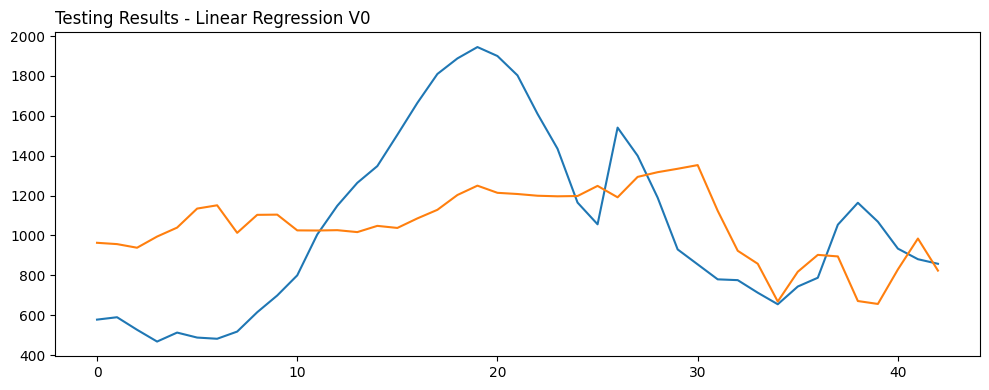

In [149]:
model_result = model_linear.predict(X)

checking_results(model_result, y)
plotting_results(X.index, y, model_result, "Linear Regression", "V0")

[18:30:58] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0fdc6d574b9c0d168-1\xgboost\xgboost-ci-windows\src\objective\regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
Results of MAE: 65.623
Results of MSE: 8517.097


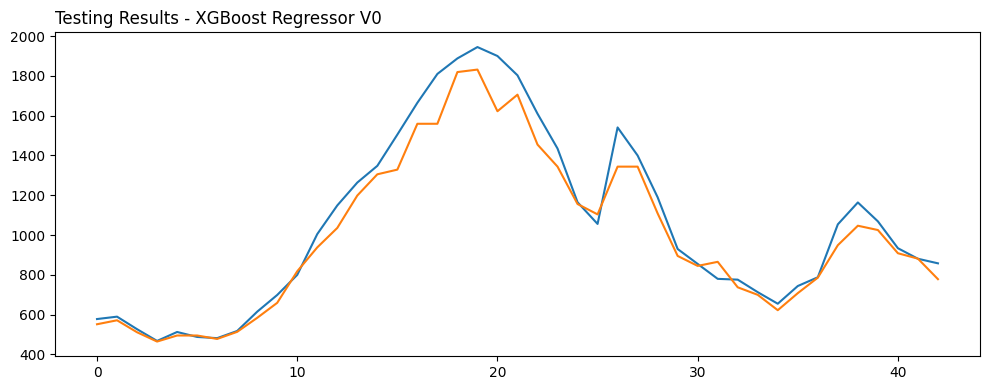

In [150]:
model_xgboost = xg.XGBRegressor(objective ='reg:linear', n_estimators = 10)
model_xgboost.fit(X, y)
xgboost_results = model_xgboost.predict(X)

checking_results(xgboost_results, y)
plotting_results(X.index, y, xgboost_results, "XGBoost Regressor", "V0")

## Making Predictions with both models

In [151]:
output_prediction_linear = model_linear.predict(df_to_predict)
output_prediction_xgboost = model_xgboost.predict(df_to_predict)

In [152]:
# Making the entire range of dates
total_range = date_range_real.tolist()
total_range.extend(date_range_prediction)

In [153]:
list_of_prices_linear = df_completo["price_hot_rolled_coil"].to_list()
list_of_prices_xgboost = df_completo["price_hot_rolled_coil"].to_list()

list_of_prices_linear.extend(output_prediction_linear)
list_of_prices_xgboost.extend(output_prediction_xgboost)

In [154]:
df_output = pd.DataFrame(data=total_range, columns=["date"])
df_output["price_linear"] = list_of_prices_linear
df_output["price_xgboost"] = list_of_prices_xgboost
df_output["price_real"] = df_completo["price_hot_rolled_coil"]

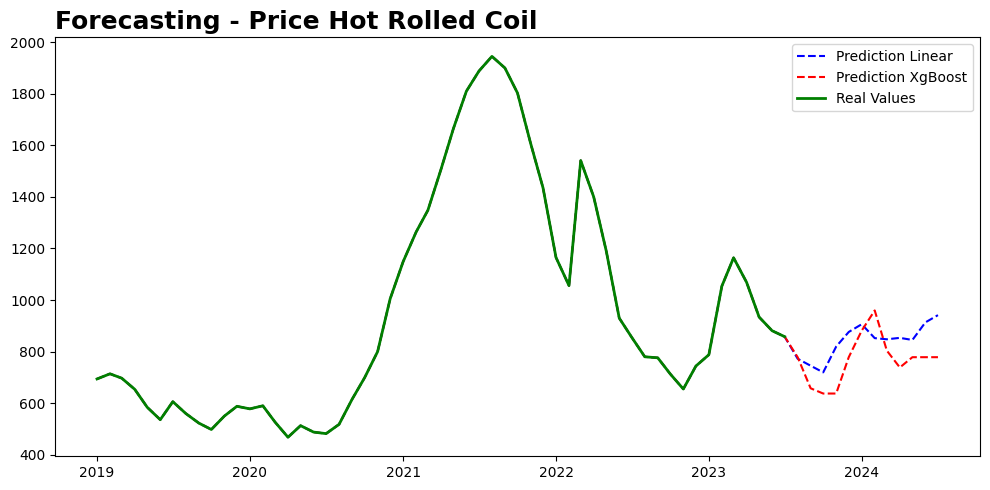

In [155]:
plt.figure(figsize=(10,5))
plt.plot(df_output["date"], df_output["price_linear"], color="blue", ls="--")
plt.plot(df_output["date"], df_output["price_xgboost"], color="red", ls="--")
plt.plot(df_output["date"], df_output["price_real"], color="green", lw=2)
plt.title("Forecasting - Price Hot Rolled Coil", loc="left", fontweight="bold", size=18)
plt.legend(["Prediction Linear", "Prediction XgBoost", "Real Values"])
plt.tight_layout()
plt.show()

In [156]:
## Creating data output
export_path = __ROOT_PATH__ / "export"
file_name = "output_data.xlsx"

with pd.ExcelWriter(export_path / file_name) as writer:
    df_output.to_excel(
        excel_writer=writer,
        sheet_name="prediction_data",
        index=False
    )